## Constructing a Classical Shadow

Two different ensembles can be considered for selecting the random unitaries $U$:

1. Random $n$-qubit Clifford circuits.

2. Tensor products of random single-qubit Clifford circuits.

Single-qubit Clifford circuits rotate the measurement basis to one of the Pauli eigenbases, so ensemble 2 is equivalent to measuring single shots of single-qubit Pauli observables on all qubits.

Ensemble 2 is more NISQ friendly. We focus on it in this notebook.

This ensemble comes with a significant drawback: the shadow norm $\|O_i\|^2_{\text{shadow}}$ becomes dependent on the locality $k$ of the observables that we want to estimate:

$$
\|O_i\|^2_{\text{shadow}} \leq 4^k \|O_i\|^2_{\infty}.
$$

Say that we want to estimate the single expectation value of a Pauli observable $\langle X_1 \otimes X_2 \otimes \dots \otimes X_n \rangle$. Estimating this from repeated measurements would require $1 / \varepsilon^2$ samples. This can be understood from the CLT: the error in the mean of $N$ samples scales as $1/\sqrt{N}$. Hence, if we want this error to be $1/\sqrt{N} \leqslant \varepsilon$, we need at least $N = 1/\varepsilon^2$ samples.

However, we would need an exponentially large shadow due to the $4^n$ appearing in the bound. Therefore, classical shadows based on Pauli measurements only offer an advantage when we have to measure a large number of observables with modest locality.


In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(666)

A classical shadow is a collection of $N$ individual snapshots $\hat{\rho}_i$ of an unknown state $\rho$:
$$
S(\rho, N) = \left\{ \hat{\rho}_1 = \mathcal{M}^{-1} \left( U_1^\dagger \ket{b_1} \bra{b_1} U_1 \right), \dots, \hat{\rho}_N = \mathcal{M}^{-1} \left( U_N^\dagger \ket{b_N} \bra{b_N} U_N \right) \right\}.
$$

Each snapshot is obtained as follows:
1. The quantum state $\rho$ is prepared (e.g. with a circuit).
2. We select a random unitary $U$ from the ensemble $\mathcal{U}$ and apply it to the state $\rho \mapsto U \rho U^{\dagger}$.
3. We perform a computational basis measurement.
4. The snapshot is recorded as the observed eigenvalue (1 for the state $|0\rangle$, -1 for the state $|1\rangle$), together with the index of the randomly selected unitary $U$.

In [2]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits, draw=False):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (1, -1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    
    # define the unitary ensemble \mathcal{U} as the single-qubit Clifford circuit (equivalent to measuring a Pauli)
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]
    
    # array of shape (shadow_size, num_qubits). Each row contains the "index" of a Pauli matrix to be applied to the qubit in its corresponding column
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))
    
    for snapshot in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        # set up observables and the qubits on which they act
        obs = [unitary_ensemble[int(unitary_ids[snapshot, qubit])](wires=qubit) for qubit in range(num_qubits)]
        # store values of outcomes
        outcomes[snapshot, :] = circuit_template(params, observable=obs)
    
    if draw:
        print("Snapshot:", snapshot)
        print(qml.draw(circuit_template, level="device")(params, observable=obs))
        print()
    
    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)


In [3]:
shadow_size = 3
num_qubits = 3

unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]
    
# array of shape (shadow_size, num_qubits). Each row contains the "index" of a Pauli matrix to be applied to the qubit in its corresponding column
unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
outcomes = np.zeros((shadow_size, num_qubits))

for snapshot in range(shadow_size):
    # for each snapshot, add a random Pauli observable at each location
    # select observables and perform measurement on qubit
    obs = [unitary_ensemble[int(unitary_ids[snapshot, qubit])](wires=qubit) for qubit in range(num_qubits)]
    print(obs)


[X(0), Z(1), Y(2)]
[Z(0), Z(1), Z(2)]
[Y(0), Z(1), X(2)]


We create a 2-qubit device that applies an $RY(\theta_k)$ rotation to each qubit $k$.

In [4]:
num_qubits = 2

# 2-qubit device with only one shot (one measurement)
dev = qml.device("default.qubit", wires=num_qubits, shots=1)

@qml.qnode(dev)
def local_qubit_rotation_circuit(params, **kwargs):
    # extract observables
    observables = kwargs.pop("observable")
    
    for w in dev.wires:
        # for each wire (a.k.a. qubit), apply an RY rotation of angle params[w]
        qml.RY(phi=params[w], wires=w)
    
    # return expectation value of each observable
    return [qml.expval(obs) for obs in observables]

Run classical shadows and collect performance data

In [5]:
elapsed_times = []
shadows = []

# sample two angle values from standard normal distribution
params = np.random.randn(2)
# params = np.array([0, np.pi])

for num_snapshots in [10, 100, 1000]:
    start = time.time()
    # print("Shadow size:", num_snapshots)
    shadow = calculate_classical_shadow(circuit_template=local_qubit_rotation_circuit, 
                                        params=params, shadow_size=num_snapshots, 
                                        num_qubits=num_qubits)
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)

**Understanding the outputs**: each shadow consists of two matrices. Each column of these matrices corresponds to a different qubit. The first matrix contains the standard-basis-measurement outcomes of each qubit. The second matrix contains which unitary was applied.

In [6]:
print(shadows[0][0].shape) # shape of first matrix of first shadow (with size 10)
print(shadows[0][0]) # std-basis-measurement outcomes for each qubit
print(shadows[0][1]) # unitaries that were applied to each qubit

(10, 2)
[[-1.  1.]
 [ 1.  1.]
 [ 1. -1.]
 [-1.  1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]
[[0 2]
 [1 0]
 [2 0]
 [1 2]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 2]]


Plot the computational time to get the shadow for each size.

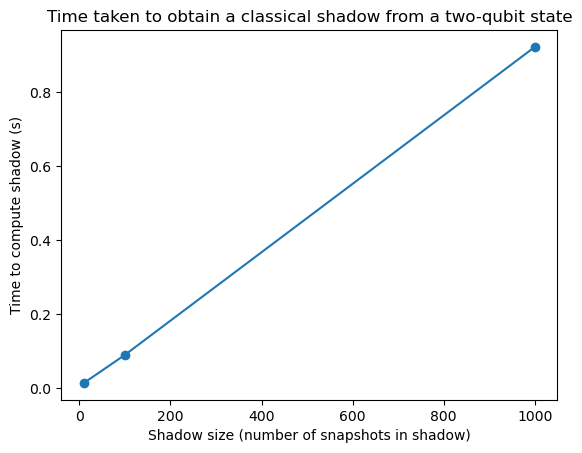

In [7]:
plt.plot([10, 100, 1000], elapsed_times, marker="o")
plt.title("Time taken to obtain a classical shadow from a two-qubit state")
plt.xlabel("Shadow size (number of snapshots in shadow)")
plt.ylabel("Time to compute shadow (s)")
plt.show()

## State Reconstruction from a Classical Shadow

We can verify whether the classical shadow approximates the exact state $\rho$ we want to estimate. To do so, we recall that we can approximate $\rho$ by the average, over all snapshots, of the inverses of the measurement channel applied to these snapshots: if we measure the state $|b\rangle$ in the computational basis, we can undo the rotation $U$ and store the resulting state in classical memory: $|b\rangle \mapsto U^{\dagger} |b\rangle \langle b| U$. 

Earlier in the notebook, we viewed the average over these snapshots as a measurement channel:
$$
\mathcal{M}(\rho) := \mathbb{E}\left[ U^{\dagger} |b\rangle \langle b| U \right]
$$
Now, we can invert this channel to obtain an approximation for $\rho$:
$$
\rho = \mathbb{E} \left[ \mathcal{M}^{-1} \left( U^{\dagger} |b\rangle \langle b| U \right) \right]
$$

Inverting the channel seems complicated. Huang et al., however, prove that for Pauli measurements we end up with
$$
\rho = \mathbb{E}[\hat{\rho}], \quad \text{where} \quad \hat{\rho} = \bigotimes_{j=1}^{n} \left( 3U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j - \mathbb{I} \right)
$$
In this formula, $\hat{\rho}$ is a snapshot state reconstructed from a single sample in the classical shadow, and $\rho$ is the average, over all snapshots, of these reconstructions $\hat{\rho}$. Note that
$$
|\hat{b}\rangle = |\hat{b}_1 \rangle \otimes \dots \otimes |\hat{b}_n\rangle, \quad \text{where} \quad \hat{b}_1, \dots, \hat{b}_n \in \{0, 1\}.
$$
Also,
$$
\text{Tr}(\hat{\rho}) = \prod_{j=1}^n \text{Tr}\left( 3U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j - \mathbb{I} \right) = \prod_{j=1}^n (3\cdot 1 - 2) = 1
$$

Original theorem (note the definition of the $U_j$: they are a decomposition of each Pauli matrix):
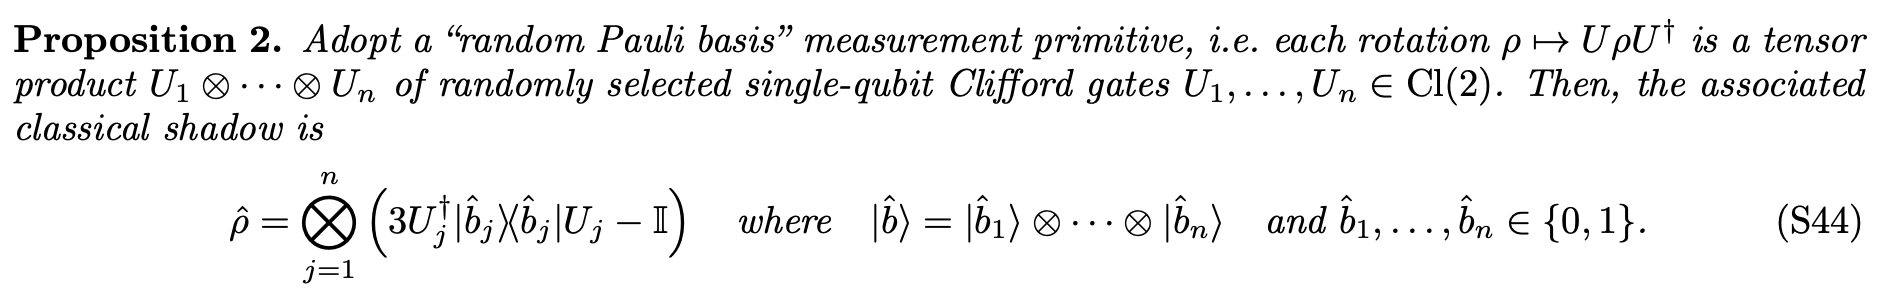

In our case, we know that single-qubit Clifford measurements are equivalent to measuring single-qubit Pauli observables. Thus, for instance, measuring the state $H\ket{\Psi}$ in the computational basis is equivalent to measuring $\ket{\Psi}$ in the Pauli-$X$ basis, since $H\ket{0} = \ket{+}$. Hence, because $\sigma_x = H \sigma_z H$, we have
$$
\underbrace{\bra{\Psi}H^{\dagger} \sigma_z H \ket{\Psi}}_{\text{in the computational basis}} = \underbrace{\bra{\Psi} \sigma_x \ket{\Psi}}_{\text{in the Pauli-X eigenbasis}}
$$


In [8]:
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.
     
     Unitary ensemble must be Pauli measurements!

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.
        obs_list (array): Indices for the applied Pauli measurement.

    Returns:
        Numpy array with the reconstructed snapshot. (density matrix)
    """
    
    num_qubits = len(b_list)
    
    # computational basis states
    zero_state = np.array([[1, 0],
                           [0, 0]])
    one_state = np.array([[0, 0],
                          [0, 1]])
    
    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex) # S^{\dagger}
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))
    
    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    # matrices to change from Pauli_k eigenbasis to Pauli_Z eigenbasis. These are the unitaries we apply to the prepared state to measure in the Pauli bases
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        # select obtained basis state from basis measurement depending on the std-basis-meas outcome
        state = zero_state if b_list[i] == 1 else one_state 
        U = unitaries[int(obs_list[i])]
        
        # apply equation of inverse channel
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)
        
    return rho_snapshot



def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    
    num_snapshots, num_qubits = shadow[0].shape
    
    # classical values obtained from std-basis-measurements, Pauli measurements used
    b_lists, obs_lists = shadow
    
    # average over snapshot states
    # initialize to zero matrix of shape (2^n, 2^n)
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])
        
    return shadow_rho / num_snapshots


### Example: Reconstruction of a Bell State

Define the bell state 
$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \left(|00\rangle + |11\rangle \right)
$$
and try to reconstruct it from its shadow.

To do so, define a single-shot device and create a circuit that constructs and measures the Bell state $|\Phi^+\rangle$.

In [48]:
num_qubits = 2

dev = qml.device("default.qubit", wires=num_qubits, shots=1)

# circuit to create a Bell state and measure it in the bases specified by the 'observable' keyword argument.
@qml.qnode(dev)
def first_bell(params, **kwargs):
    observables = kwargs.pop("observable")

    # map |0> to |+>, now we have |+> @ |1>
    qml.Hadamard(0)
    # now CNOT the |01> component
    qml.CNOT(wires=[0, 1])
    
    return [qml.expval(O) for O in observables]


@qml.qnode(dev)
def second_bell(params, **kwargs):
    observables = kwargs.pop("observable")

    qml.X(0)
    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])
    
    return [qml.expval(O) for O in observables]


@qml.qnode(dev)
def third_bell(params, **kwargs):
    observables = kwargs.pop("observable")

    qml.X(1)
    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])
    
    return [qml.expval(O) for O in observables]


@qml.qnode(dev)
def fourth_bell(params, **kwargs):
    observables = kwargs.pop("observable")

    qml.X(1)
    qml.Hadamard(0)
    qml.Z(0)
    qml.Z(1)
    qml.CNOT(wires=[0, 1])
    
    return [qml.expval(O) for O in observables]

Now construct a classical shadow of this state. Shadow size = 1000.

In [49]:
num_snapshots = 1000

shadow = calculate_classical_shadow(circuit_template=first_bell, params=[], 
                                    shadow_size=num_snapshots, num_qubits=num_qubits)

# reconstruct Bell state using its shadow
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=3))

[[ 0.512+0.j     0.023+0.027j  0.039-0.019j  0.495-0.016j]
 [ 0.023-0.027j -0.028+0.j    -0.004+0.007j  0.021-0.028j]
 [ 0.039+0.019j -0.004-0.007j -0.034+0.j     0.014+0.009j]
 [ 0.495+0.016j  0.021+0.028j  0.014-0.009j  0.551+0.j   ]]


Compare reconstructed state with Bell state.

In [50]:
first_state = np.array([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]])
second_state = np.array([[0.5, 0, 0, -0.5], [0, 0, 0, 0], [0, 0, 0, 0], [-0.5, 0, 0, 0.5]])
third_state = np.array([[0, 0, 0, 0], [0, 0.5, 0.5, 0], [0, 0.5, 0.5, 0], [0, 0, 0, 0]])
fourth_state = np.array([[0, 0, 0, 0], [0, 0.5, -0.5, 0], [0, -0.5, 0.5, 0], [0, 0, 0, 0]])


def operator_2_norm(O):
    return np.sqrt(np.trace(O.conjugate().transpose() @ O))

# operator_2_norm(bell_state - shadow_state)

Improve approximation by increasing shadow size. We will run the estimation several times to include the variance of the results.

In [54]:
number_of_runs = 10
snapshots_range = [10, 1000, 3000, 6000]
# snapshots_range = [10, 1000]

distances = np.zeros((number_of_runs, len(snapshots_range), 4))

for i in range(number_of_runs):
    for j, num_snapshots in enumerate(snapshots_range):
        shadow = calculate_classical_shadow(circuit_template=first_bell, params=[], 
                                            shadow_size=num_snapshots, num_qubits=num_qubits)
        # reconstruct state from shadow
        shadow_state = shadow_state_reconstruction(shadow)
        
        distances[i, j, 0] = np.real(operator_2_norm(first_state - shadow_state))
        
        
        shadow = calculate_classical_shadow(circuit_template=second_bell, params=[], 
                                            shadow_size=num_snapshots, num_qubits=num_qubits)
        # reconstruct state from shadow
        shadow_state = shadow_state_reconstruction(shadow)
        
        distances[i, j, 1] = np.real(operator_2_norm(second_state - shadow_state))
        
        
        shadow = calculate_classical_shadow(circuit_template=third_bell, params=[], 
                                            shadow_size=num_snapshots, num_qubits=num_qubits)
        # reconstruct state from shadow
        shadow_state = shadow_state_reconstruction(shadow)
        
        distances[i, j, 2] = np.real(operator_2_norm(third_state - shadow_state))
        
        
        shadow = calculate_classical_shadow(circuit_template=fourth_bell, params=[], 
                                            shadow_size=num_snapshots, num_qubits=num_qubits)
        # reconstruct state from shadow
        shadow_state = shadow_state_reconstruction(shadow)
        
        distances[i, j, 3] = np.real(operator_2_norm(fourth_state - shadow_state))
        

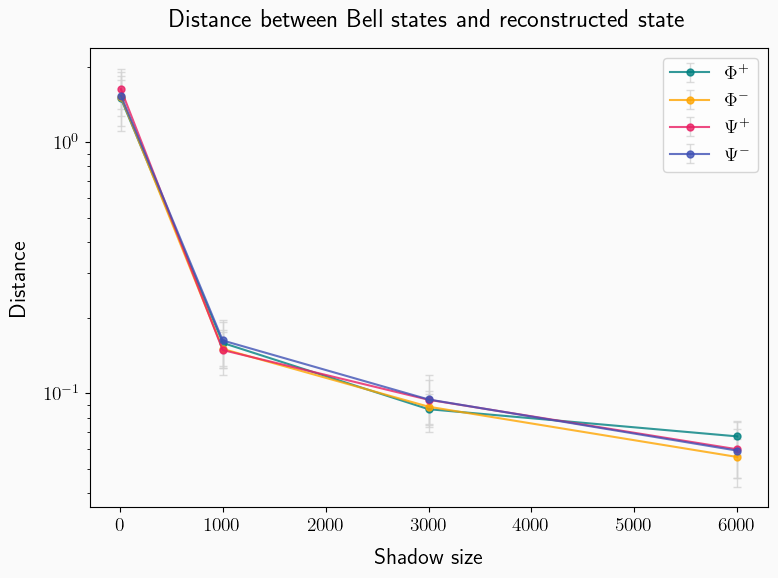

In [100]:
# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor('#FAFAFA')
ax.set_facecolor('#FAFAFA')

names = [r"$\Phi^+$", r"$\Phi^-$", r"$\Psi^+$", r"$\Psi^-$"]
colors = ['#008080', '#FFA500', '#E91E63', '#3F51B5']

# Plot with error bars
for i in range(4):
    ax.errorbar(x=snapshots_range, 
                y=np.mean(distances[:,:,i], axis=0), 
                yerr=np.std(distances[:,:,i], axis=0), 
                fmt='o-', color=colors[i], ecolor='lightgray', elinewidth=1, capsize=3, markersize=5, label=names[i], alpha=0.8)
# ax.errorbar(x=snapshots_range, 
#             y=np.mean(distances[:,:,0], axis=0), 
#             yerr=np.std(distances[:,:,0], axis=0), 
#             fmt='o-', color="teal", ecolor='lightgray', elinewidth=2, capsize=4, markersize=5)

# Titles and labels
ax.set_title(r"Distance between Bell states and reconstructed state", pad=15)
ax.set_xlabel(r"Shadow size", labelpad=10)
ax.set_ylabel(r"Distance", labelpad=10)
plt.legend()
ax.set_yscale("log")

# Tight layout
plt.tight_layout()

# Show plot
plt.show()
fig.savefig("shadow_size_distance.pdf", dpi=800)

## Estimate Pauli Observables

So far, we have used classical shadows to reconstruct the state. However, the goal of classical shadows is not to perform full tomography, which takes an exponential amount of resources. Instead, we want to use the shadows to efficiently calculate **linear functions** of a quantum state. To do this, we write a function *estimate_shadow_observable* that takes in the previously constructed shadow $S(\rho, N) = \{\hat{\rho}_1, \dots, \hat{\rho}_N\}$ and estimates any observable via a **median of means estimation**.

This makes the estimator more robust to outliers and is required to formally prove the aforementioned theoretical bound. The procedure is simple: split up the shadow into $K$ equally sized chunks and estimate the mean for each of these chunks: for $1\leqslant k \leqslant K$, we have the $k$-th average
$$
\hat{\rho}_{(k)} = \frac{1}{\lfloor N/K \rfloor} \sum_{i = (k-1)\lfloor N/K \rfloor + 1}^{k \lfloor N/K \rfloor} \hat{\rho}_i \implies \langle O_{(k)} \rangle = \text{Tr}(O\hat{\rho}_{(k)}),
$$
and our median of means estimation will be
$$
\langle O \rangle = \text{median}\{\langle O_{(1)}\rangle, \dots, \langle O_{(K)} \rangle\}
$$

Assume that $O = \bigotimes_{j=1}^n P_j$, where each $P_j \in \{\mathbb{I}, X, Y, Z\}$. Then, using the inverse of the measurement channel $\hat{\rho} = \bigotimes_{j=1}^{n} \left( 3U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j - \mathbb{I} \right)$, we have
$$
\langle O_{(k)} \rangle = \text{Tr}(O\hat{\rho}_{(k)}) = \text{Tr}\left[\bigotimes_{j=1}^{n} P_j \left( 3U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j - \mathbb{I} \right)\right] = \prod_{j=1}^n \text{Tr}\left(3 P_j U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j  \right)
$$
where we have assumed that at least one $P_j \neq \mathbb{I}$ for some $j\in \{1, \dots, n\}$. Then, since $\text{Tr}(P_j) = 0$ in this case, the second term vanishes. Now, for the remaining term inside the product, we can rewrite it as 
$$
\text{Tr}\left(3 P_j U_j^\dagger \ket{\hat{b}_j} \bra{\hat{b}_j} U_j  \right) = 3 \cdot \text{Tr}\left(P_j U_j^\dagger U_j \ket{\hat{b}_j} \bra{\hat{b}_j} \right) = 3 \cdot \text{Tr}\left( P_j \ket{\hat{b}_j} \bra{\hat{b}_j}\right) = 3 \cdot \bra{\hat{b}_j} P_j \ket{\hat{b}_j}. 
$$
Recall that $\ket{\hat{b}_j}$ is measured in one of the Pauli bases, i.e. $\ket{\hat{b}_j} \in \left\{\ket{0}, \ket{1}, \ket{+}, \ket{-}, \ket{+i}, \ket{-i}\right\}$. Thus, this term will be zero whenever $P_j$ corresponds to a different Pauli matrix than the one in which $\ket{\hat{b}_j}$ is measured. For instance, the expected value of spin in the x direction for a $\bra{0}$ state is $\bra{0} X \ket{0} = 0$. However, when $P_j$ corresponds to the basis in which $\ket{\hat{b}_j}$ is measured, then we can have $\bra{\hat{b}_j} P_j \ket{\hat{b}_j} = \pm 1$. Thus, in this case, the term in the product will evaluate to $\pm 3$. In summary, if a single matrix $U_j$ in the snapshot does not match the one in $O$, the whole product evaluates to zero, because in this case the state $\ket{\hat{b}_j}$ will be in a different Pauli eigenbasis (since it has been transformed via $U_j$) than the Pauli eigenbasis of $P_j$. As a result, calculating the mean estimator can be reduced to counting the number of exact matches in the shadow with the observable, and multiplying with the appropriate sign.

TODO: To see why this makes intuitive sense, imagine we start with our system of $n$ qubits prepared in some state $\ket{\Psi}$. Now, what we have done by using single-qubit Clifford measurements is to project each of the $n$ qubits, separately, into one of the eigenstates of the Pauli matrices.

In [66]:
def estimate_shadow_obervable(shadow, observable, k=10):
    """
    Adapted from https://github.com/momohuang/predicting-quantum-properties
    Calculate the estimator E[O] = median(Tr{rho_{(k)} O}) where rho_(k)) is set of k
    snapshots in the shadow. Use median of means to ameliorate the effects of outliers.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        observable (qml.Observable): Single PennyLane observable consisting of single Pauli
            operators e.g. qml.PauliX(0) @ qml.PauliY(1).
        k (int): number of splits in the median of means estimator.

    Returns:
        Scalar corresponding to the estimate of the observable.
    """
    shadow_size, num_qubits = shadow[0].shape
    
    # convert Pennylane observables to indices
    map_name_to_int = {"PauliX": 0, "PauliY": 1, "PauliZ": 2}
    # check observable is of type Pauli
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        # extract decomposition of observable and wires on which it acts
        target_obs, target_locs = np.array([map_name_to_int[observable.name]]), np.array([observable.wires[0]])
        # print("first if")
    else:
        target_obs, target_locs = np.array([map_name_to_int[o.name] for o in observable.operands]), np.array([o.wires[0] for o in observable.operands])
        # print("second if")
        
    # print("target_obs", target_obs)
    # print("target_locs", target_locs)
    
    # classical values
    b_lists, obs_lists = shadow
    means = []
    
    # loop over the splits of the shadow
    for i in range(0, shadow_size, shadow_size//k):
        # assign the splits temporarily
        b_lists_k, obs_lists_k = (b_lists[i: i + shadow_size//k], obs_lists[i: i + shadow_size//k])
        
        # print(obs_lists_k.shape)
        # print(obs_lists_k)
        # find exact matches for the observable of interest at the specified locations
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)
        
        # print(indices)
        
        # catch the edge case where ther is no match in the chunk
        if sum(indices) > 0:
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)
            means.append(np.sum(product) / sum(indices))
        else:
            means.append(0)
            
    return np.median(means)

In [67]:
num_qubits = 2
shadow_size = 50

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(params, **kwargs):
    observable = kwargs.pop("observable")
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliX(0) @ qml.PauliZ(1))

o = qml.PauliX(0) @ qml.PauliZ(1)
shadow = calculate_classical_shadow(circuit_template=circuit, params=[], shadow_size=shadow_size, num_qubits=num_qubits, draw=True)


print("True value:", circuit([], observable=o))
print("Estimated value", estimate_shadow_obervable(shadow, o, 5))

Snapshot: 49
0: ──H─┤ ╭<X@Z>
1: ────┤ ╰<X@Z>

True value: 0.9999999999999996
Estimated value 0.9999999999999991


/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Next, we can define a function that calculates the number of samples required to get an error $\varepsilon$ on our estimator for a given set of observables.

In [84]:
def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(o) for o in observables) / error ** 2
    return int(np.ceil(N * K)), int(K)

## Estimating a simple set of observables

We define the following set of observables:
$$
O = \sum_{i=0}^{n-1} \left( X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1} \right)
$$
and using our *shadow_bound* function, we calculate how many shadows we need to ensure that the absolute error of all individual terms in $O$ satisfies
$$
|\langle O_i \rangle_{\text{shadow}} - \langle O_i \rangle_{\text{exact}}| \leqslant \varepsilon
$$
for all $i = 1, \dots, M$.

We verify the bound by considering a grid of errors $\varepsilon_i$ and checking that $|\langle O_i \rangle_{\text{shadow}} - \langle O_i \rangle_{\text{exact}}|$ stays below this value for the shadow size calculated in *shadow_bound*. First, we get the classical shadow estimate.




In [85]:
num_qubits = 10
dev = qml.device("default.qubit", wires=num_qubits, shots=1)

def circuit_base(params, **kwargs):
    observables = kwargs.pop("observable")
    for w in range(num_qubits):
        qml.Hadamard(wires=w)
    for w in dev.wires[:-1]:
        qml.CNOT(wires=[w, w+1])
    for w in dev.wires:
        qml.RZ(params[w+num_qubits], wires=w)
    
    return [qml.expval(o) for o in observables]

circuit = qml.QNode(circuit_base, dev)
params = np.random.randn(2*num_qubits)

In [86]:
list_of_observables = ([qml.PauliX(i-1) @ qml.PauliX(i) @ qml.PauliX(i+1) for i in range(1, num_qubits-1)] +
                       [qml.PauliY(i-1) @ qml.PauliY(i) @ qml.PauliY(i+1) for i in range(1, num_qubits-1)] +
                       [qml.PauliZ(i-1) @ qml.PauliZ(i) @ qml.PauliZ(i+1) for i in range(1, num_qubits-1)])

In [88]:
shadow_size_bound, k = shadow_bound(error=2e-1, observables=[qml.matrix(o) for o in list_of_observables])
shadow_size_bound, k

(14410, 16)

In [89]:
epsilon_grid = [1 - 0.1*x for x in range(9)]
shadow_sizes = []
estimates = []

for error in epsilon_grid:
    # get the number of samples needed so that the absolute error < epsilon.
    shadow_size_bound, k = shadow_bound(error=error, observables=[qml.matrix(o) for o in list_of_observables])
    shadow_sizes.append(shadow_size_bound)
    print(f"Error: {error}")
    print(f"\t{shadow_size_bound} samples required")
    print(f"\tChunks: {k}")
    # calculate shadow of appropiate size
    shadow = calculate_classical_shadow(circuit, params, shadow_size_bound, num_qubits)
    # estimate all the observables in O
    estimates.append([estimate_shadow_obervable(shadow, o, k) for o in list_of_observables])

Error: 1.0
	577 samples required
	Chunks: 16
Error: 0.9
	712 samples required
	Chunks: 16
Error: 0.8
	901 samples required
	Chunks: 16
Error: 0.7
	1177 samples required
	Chunks: 16
Error: 0.6
	1602 samples required
	Chunks: 16
Error: 0.5
	2306 samples required
	Chunks: 16
Error: 0.3999999999999999
	3603 samples required
	Chunks: 16
Error: 0.29999999999999993
	6405 samples required
	Chunks: 16
Error: 0.19999999999999996
	14410 samples required
	Chunks: 16


Calculate exact value by changing device setup (do not include shots argument to make it exact)

In [90]:
dev_exact = qml.device("default.qubit", wires=num_qubits)

circuit = qml.QNode(circuit_base, dev_exact)

expval_exact = [circuit(params, observable=[o]) for o in list_of_observables]

/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Finally, we plot the errors $\varepsilon_i$ and checking that $|\langle O_i \rangle_{\text{shadow}} - \langle O_i \rangle_{\text{exact}}|$ for all individual terms in $O$. We expect these errors to always be smaller that $\varepsilon$.

In [ ]:
len(estimates) # should be equal to the number of errors
len(estimates[0]) # should be equal to the number of observables in observables_list

24

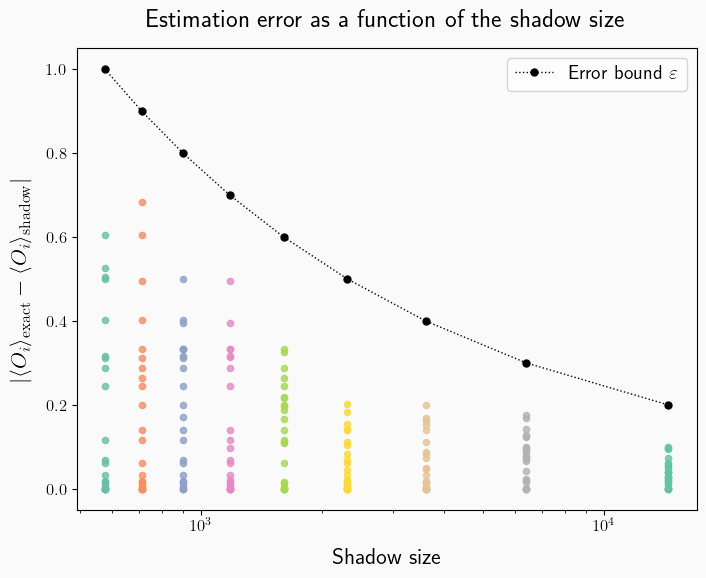

In [106]:
import matplotlib.pyplot as plt
from cycler import cycler

# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set a nice color palette (Set2)
c = plt.get_cmap('Set2').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=c)

# Create figure and axis manually
fig, ax = plt.subplots(figsize=(8,6))

# Set background color
fig.patch.set_facecolor('#FAFAFA')  # Full figure background
ax.set_facecolor('#FAFAFA')          # Inside the plot area

# Plot scatter points
for j, error in enumerate(epsilon_grid):
    ax.scatter(
        [shadow_sizes[j] for _ in estimates[j]], 
        [np.abs(obs - estimates[j][i]) for i, obs in enumerate(expval_exact)],
        s=20, alpha=0.8
    )

# Plot the error bound line
ax.plot(
    shadow_sizes, 
    [e for e in epsilon_grid], 
    linestyle="dotted", color="black", 
    label=r"Error bound $\varepsilon$", 
    marker="o", markersize=5, linewidth=1
)

# Labels and legend
ax.set_xlabel(r"Shadow size", labelpad=10)
ax.set_ylabel(r"$|\langle O_i \rangle_{\mathrm{exact}} - \langle O_i \rangle_{\mathrm{shadow}}|$", labelpad=10)
ax.set_title(r"Estimation error as a function of the shadow size", pad=15)
ax.set_xscale("log")
ax.legend()


# Save and show
plt.savefig("shadow_error.pdf", dpi=800, facecolor=fig.get_facecolor())
plt.show()


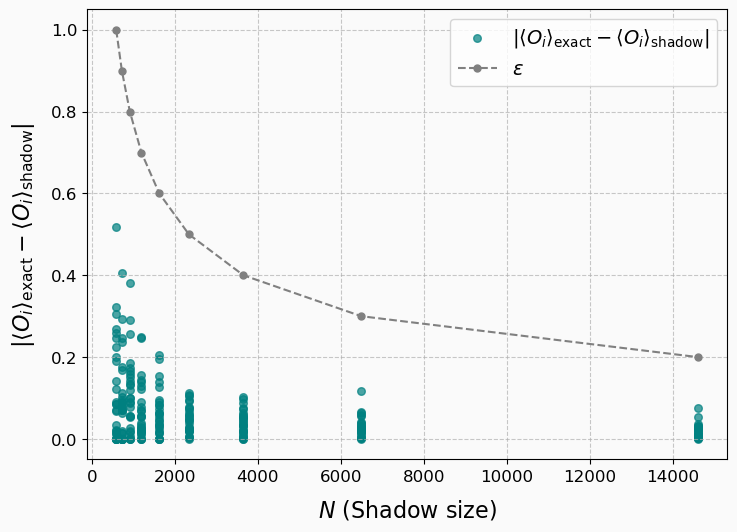

In [23]:
import matplotlib.pyplot as plt

# LaTeX style ON
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(8,6))

for j, error in enumerate(epsilon_grid):
    ax.scatter(
        [shadow_sizes[j]] * len(estimates[j]), 
        [np.abs(obs - estimates[j][i]) for i, obs in enumerate(expval_exact)],
        color='teal', s=30, alpha=0.7, label=r"$|\langle O_i \rangle_{\text{exact}} - \langle O_i \rangle_{\text{shadow}}|$" if j == 0 else ""
    )

ax.plot(
    shadow_sizes, epsilon_grid, 
    linestyle="--", color="gray", marker="o", markersize=5, label=r"$\epsilon$"
)

ax.set_xlabel(r"$N$ (Shadow size)", labelpad=10)
ax.set_ylabel(r"$|\langle O_i \rangle_{\text{exact}} - \langle O_i \rangle_{\text{shadow}}|$", labelpad=10)

ax.grid(True, linestyle="--", alpha=0.7)
ax.legend()

fig.patch.set_facecolor('#FAFAFA')
ax.set_facecolor('#FAFAFA')

# Use subplots_adjust instead of tight_layout
fig.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)

plt.show()
